# Common code

In [73]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
from sklearn.metrics import accuracy_score
from idlmam import train_simple_network, LastTimeStep, EmbeddingPackable

train_epochs = 10

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

loss_func = nn.CrossEntropyLoss()

score_funcs = {'Accuracy': accuracy_score}

B = 16

# Excercise 1
Modify `LanguageNameDataset` so the `vocabulary` object in the constructor does not need to be passed in as an argument but instead can be inferred from the input dataset. This means you need to iterate through the dataset and create a dictionary with all the characters actually seen. One way to implement this is to create a default value `vocabulary=None` and use `is vocabulary None:` to change behavior.

In [74]:
zip_file_url = "https://download.pytorch.org/tutorial/data.zip"

import requests, zipfile, io

r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [75]:
name_language_data = {}

#We will use some code to remove UNICODE tokens to make life easy for us processing wise
#e.g., convert something like "Ślusàrski" to Slusarski
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}
for i in range(n_letters):
    alphabet[all_letters[i]] = i


# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


#Loop through every language, open the zip file entry, and read all the lines from the text file.
for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            language_names = [unicodeToAscii(line).lower() for line in
                              str(myfile.read(), encoding='utf-8').strip().split("\n")]
            name_language_data[lang] = language_names

In [76]:
def dictToVocabulary(lang_name_dict):
    found_chars = set()
    for lang_names in lang_name_dict.values():
        for name in lang_names:
            for char in name:
                found_chars.add(char)
    vocabulary = {}
    for i, ch in enumerate(found_chars):
        vocabulary[ch] = i
    return vocabulary


class LanguageNameDataset(Dataset):
    def __init__(self, lang_name_dict, vocabulary=None):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.vocabulary = vocabulary or dictToVocabulary(lang_name_dict)
        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                self.data.append(sample)
                self.labels.append(y)

    def __len__(self):
        return len(self.data)

    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long
        values, according to the vocabulary used by this object.
        input_string: the string to convert to a tensor
        """
        name_vec = torch.zeros(len(input_string), dtype=torch.long)

        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]
        return name_vec

    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]
        return self.string2InputVec(name), label

In [77]:
dataset = LanguageNameDataset(name_language_data)
train_data, test_data = torch.utils.data.random_split(dataset, (len(dataset) - 300, 300))
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='test Accuracy'>

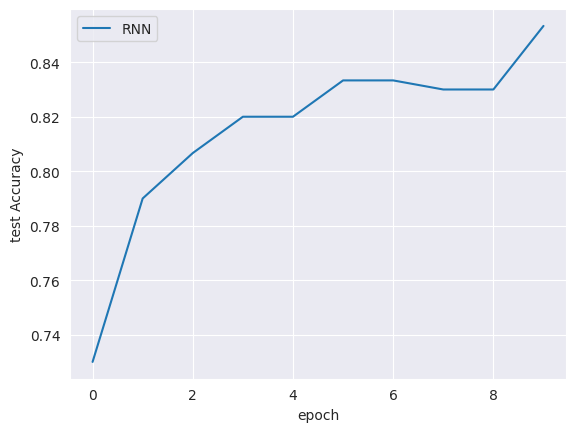

In [78]:
D = 64
vocab_size = len(dataset.vocabulary)
hidden_nodes = 256
classes = len(dataset.label_names)

first_rnn = nn.Sequential(
    nn.Embedding(vocab_size, D),  #(B, T) -> (B, T, D)
    nn.RNN(D, hidden_nodes, batch_first=True),  #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
    #the tanh activation is built into the RNN object, so we don't need to do it here
    LastTimeStep(),  #We need to take the RNN output and reduce it to one item, (B, D)
    nn.Linear(hidden_nodes, classes),  #(B, D) -> (B, classes)
)

loss_func = nn.CrossEntropyLoss()
result_e1 = train_simple_network(first_rnn, loss_func, train_loader,
                                 test_loader=test_loader, score_funcs=score_funcs,
                                 device=device, epochs=train_epochs)

sns.lineplot(x='epoch', y='test Accuracy', data=result_e1, label='RNN')

# Excercise 2
Update `LanguageNameDataset` with a flag in the constructor for `unicode=False`. Change any of the code you need to so that when `unicode=True`, Language-NameDataset instead keeps all the Unicode characters seen when `vocabulary=None` (this depends on exercise 1). Train a new RNN classifier with `unicode=True`. How does it impact the results?

**Important:** It turns out that implementatino from Excercise 1 perfectly works with unicode strings. So I'll just create a new dataset here and will train a new RNN on it.

In [79]:
namge_language_data_utf = {}

for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            language_names = [line.lower() for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
            namge_language_data_utf[lang] = language_names

dataset = LanguageNameDataset(namge_language_data_utf)
train_data, test_data = torch.utils.data.random_split(dataset, (len(dataset) - 300, 300))
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='test Accuracy'>

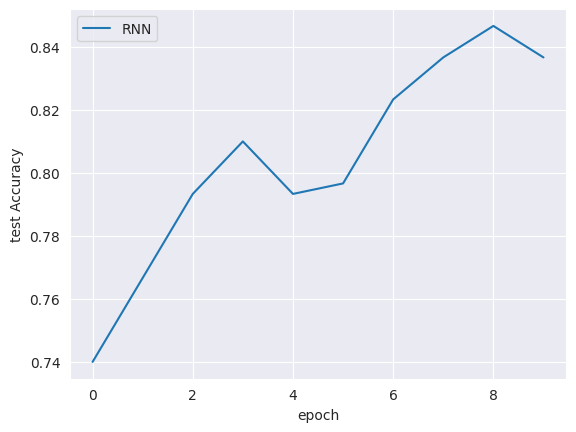

In [80]:
vocab_size = len(dataset.vocabulary)
classes = len(dataset.label_names)

first_rnn = nn.Sequential(
    nn.Embedding(vocab_size, D),  #(B, T) -> (B, T, D)
    nn.RNN(D, hidden_nodes, batch_first=True),  #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
    #the tanh activation is built into the RNN object, so we don't need to do it here
    LastTimeStep(),  #We need to take the RNN output and reduce it to one item, (B, D)
    nn.Linear(hidden_nodes, classes),  #(B, D) -> (B, classes)
)

result_e2 = train_simple_network(first_rnn, loss_func, train_loader,
                                 test_loader=test_loader, score_funcs=score_funcs,
                                 device=device, epochs=train_epochs)

sns.lineplot(x='epoch', y='test Accuracy', data=result_e2, label='RNN')

Conclusion: With UTF-8 chars indataset model performs better or at least not worse

# Excercise 3
Update `LanguageNameDataset` with a new `min_count=1` argument in the constructor. If `vocabulary=None`, it should replace any character that occurs too few times with a special "UNK" token, indicating an unknown value. How is the size of the vocabulary impacted by setting `min_count=300`, and what happens to the results?

In [81]:
UNK = "UNK"
UNK_ID = 0

def dictToVocabulary(lang_name_dict, min_count=1):
    found_chars = {}
    for lang_names in lang_name_dict.values():
        for name in lang_names:
            for char in name:
                if char in found_chars:
                    found_chars[char] += 1
                else:
                    found_chars[char] = 1
    vocabulary = {UNK: UNK_ID}
    i = UNK_ID + 1
    for ch, count in found_chars.items():
        if count >= min_count:
            vocabulary[ch] = i
            i = i + 1
    return vocabulary

class LanguageNameDataset(Dataset):
    def __init__(self, lang_name_dict, vocabulary=None, min_count=1):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.vocabulary = vocabulary or dictToVocabulary(lang_name_dict, min_count=min_count)
        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                self.data.append(sample)
                self.labels.append(y)

    def __len__(self):
        return len(self.data)

    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long
        values, according to the vocabulary used by this object.
        input_string: the string to convert to a tensor
        """
        name_vec = torch.zeros(len(input_string), dtype=torch.long)

        for pos, character in enumerate(input_string):
            if character in self.vocabulary:
                name_vec[pos] = self.vocabulary[character]
            else:
                name_vec[pos] = UNK_ID
        return name_vec

    def __getitem__(self, idx):
        name = self.data[idx]
        return self.string2InputVec(name), self.labels[idx]

In [82]:
name_language_data_utf = {}

for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            language_names = [line.lower() for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
            name_language_data_utf[lang] = language_names

dataset = LanguageNameDataset(name_language_data_utf, min_count=300)
train_data, test_data = torch.utils.data.random_split(dataset, (len(dataset) - 300, 300))
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='test Accuracy'>

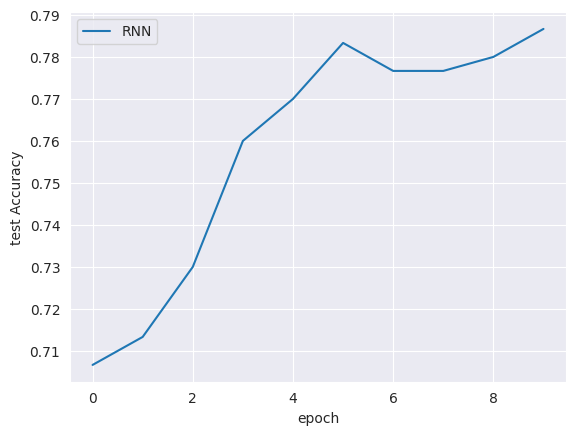

In [83]:
D = 64
hidden_nodes = 256
vocab_size = len(dataset.vocabulary)
classes = len(dataset.label_names)

first_rnn = nn.Sequential(
    nn.Embedding(vocab_size, D),  #(B, T) -> (B, T, D)
    nn.RNN(D, hidden_nodes, batch_first=True),  #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
    #the tanh activation is built into the RNN object, so we don't need to do it here
    LastTimeStep(),  #We need to take the RNN output and reduce it to one item, (B, D)
    nn.Linear(hidden_nodes, classes),  #(B, D) -> (B, classes)
)

result_e3 = train_simple_network(first_rnn, loss_func, train_loader,
                                 test_loader=test_loader, score_funcs=score_funcs,
                                 device=device, epochs=train_epochs)

sns.lineplot(x='epoch', y='test Accuracy', data=result_e3, label='RNN')

Conclustion: Training curve is less smooth, model performance after 10 epochs is slightly better

# Excercise 4
The original training/test split for this task was created by randomly sampling the dataset. Create your own function that performs stratified splitting: selecting a test set that has the same proportions of each class. How does this impact your apparent results?

In [86]:
from torch.utils.data import Subset
import random


def stratigied_split(dataset, items_to_pick):
    dataset_len = len(dataset)
    restored_dict = {}
    for i, lang in enumerate(dataset.labels):
        if lang in restored_dict:
            restored_dict[lang].append(i)
        else:
            restored_dict[lang] = [i]
    train_idxs = []
    test_idxs = []
    correction = 0

    for i, (k, v) in enumerate(restored_dict.items()):
        random.shuffle(v)
        train_items_to_pick_decimal = len(v) * items_to_pick[0] / dataset_len
        train_items_to_pick = round(len(v) * items_to_pick[0] / dataset_len)
        test_items_to_pick = round(len(v) * items_to_pick[1] / dataset_len)
        if i == len(restored_dict) - 1:
            final_round = 1 if (train_items_to_pick_decimal - train_items_to_pick) > 0.5 else -1
            correction = correction + final_round
        if test_items_to_pick > 0:
            train_items_to_pick = train_items_to_pick + correction
            test_items_to_pick = test_items_to_pick - correction
        if train_items_to_pick > 0:
            train_idxs = train_idxs + v[0:int(train_items_to_pick)]
        if test_items_to_pick > 0:
            test_idxs = test_idxs + v[-int(test_items_to_pick):]
        correction = 1 if (train_items_to_pick_decimal - train_items_to_pick) > 0.5 else -1
    return Subset(dataset, train_idxs), Subset(dataset, test_idxs)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='test Accuracy'>

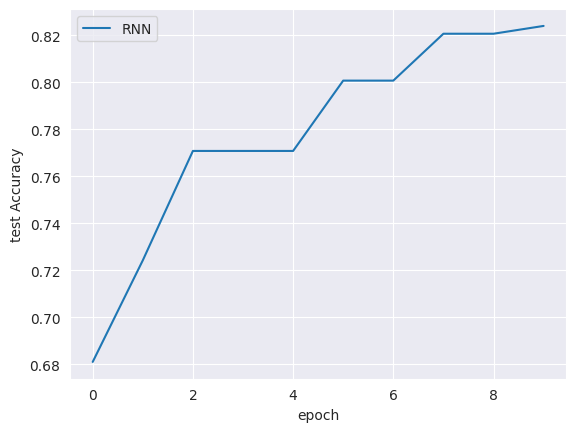

In [87]:
dataset = LanguageNameDataset(name_language_data_utf)
train_data, test_data = stratigied_split(dataset, (len(dataset) - 300, 300))
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

D = 64
hidden_nodes = 256
vocab_size = len(dataset.vocabulary)
classes = len(dataset.label_names)

first_rnn = nn.Sequential(
    nn.Embedding(vocab_size, D),  #(B, T) -> (B, T, D)
    nn.RNN(D, hidden_nodes, batch_first=True),  #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
    #the tanh activation is built into the RNN object, so we don't need to do it here
    LastTimeStep(),  #We need to take the RNN output and reduce it to one item, (B, D)
    nn.Linear(hidden_nodes, classes),  #(B, D) -> (B, classes)
)

result_e4 = train_simple_network(first_rnn, loss_func, train_loader,
                                 test_loader=test_loader,
                                 score_funcs=score_funcs,
                                 device=device, epochs=train_epochs)

sns.lineplot(x='epoch', y='test Accuracy', data=result_e4, label='RNN')

# Excercise 5
Replace the last output layer `nn.Linear(hidden_nodes, classes)` from the RNN implementation with a fully connected network with two hidden layers and one output layer. How does this impact the accuracy of the model?

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='test Accuracy'>

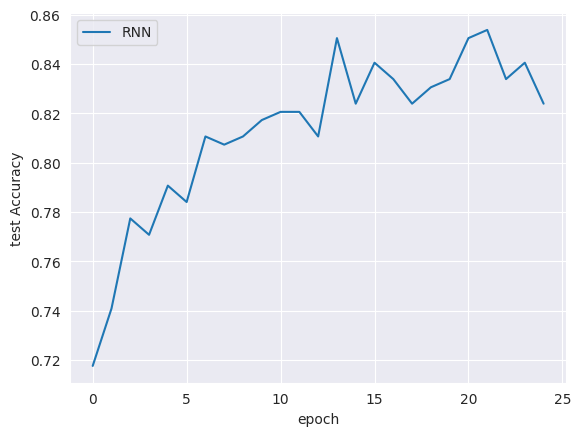

In [88]:
first_rnn = nn.Sequential(
    nn.Embedding(vocab_size, D),  #(B, T) -> (B, T, D)
    nn.RNN(D, hidden_nodes, batch_first=True),  #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
    #the tanh activation is built into the RNN object, so we don't need to do it here
    LastTimeStep(),  #We need to take the RNN output and reduce it to one item, (B, D)
    nn.Linear(hidden_nodes, hidden_nodes),
    nn.Tanh(),
    nn.Linear(hidden_nodes, hidden_nodes),
    nn.Tanh(),
    nn.Linear(hidden_nodes, classes),
)

result_e5 = train_simple_network(first_rnn, loss_func, train_loader,
                                 test_loader=test_loader,
                                 score_funcs=score_funcs,
                                 device=device, epochs=25)

sns.lineplot(x='epoch', y='test Accuracy', data=result_e5, label='RNN')

# Excercise 6
You can use the collation function to implement interesting features. To get a better handle on how it works, implement your own `collate_fn` that removes half the items from a batch of training data. Does training with two epochs of this model obtain the same results as training with one epoch of a normal `collate_fn`? Why or why not?

In [89]:
def pad_pack_and_remove_half(batch):
    num_remove = len(batch) // 2
    input_tensors = []
    labels = []
    lengths = []
    for x, y in batch[num_remove:]:
        input_tensors.append(x)
        labels.append(y)
        lengths.append(x.shape[0])
    x_padded = torch.nn.utils.rnn.pad_sequence(input_tensors, batch_first=False)

    x_packed = torch.nn.utils.rnn.pack_padded_sequence(x_padded, lengths, batch_first=False, enforce_sorted=False)
    y_batched = torch.as_tensor(labels, dtype=torch.long)

    return x_packed, y_batched

def pad_and_pack(batch):
    input_tensors = []
    labels = []
    lengths = []
    for x, y in batch:
        input_tensors.append(x)
        labels.append(y)
        lengths.append(x.shape[0])
    x_padded = torch.nn.utils.rnn.pad_sequence(input_tensors, batch_first=False)

    x_packed = torch.nn.utils.rnn.pack_padded_sequence(x_padded, lengths, batch_first=False, enforce_sorted=False)
    y_batched = torch.as_tensor(labels, dtype=torch.long)

    return x_packed, y_batched


D = 64
hidden_nodes = 256
vocab_size = len(dataset.vocabulary)
classes = len(dataset.label_names)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True, collate_fn=pad_pack_and_remove_half)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False, collate_fn=pad_and_pack)

e6_rnn = nn.Sequential(
    EmbeddingPackable(nn.Embedding(vocab_size, D)),  #(B, T) -> (B, T, D)
    nn.RNN(D, hidden_nodes, batch_first=True),  #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
    #the tanh activation is built into the RNN object, so we don't need to do it here
    LastTimeStep(),  #We need to take the RNN output and reduce it to one item, (B, D)
    nn.Linear(hidden_nodes, classes),  #(B, D) -> (B, classes)
)

result_e6_1 = train_simple_network(e6_rnn, loss_func, train_loader,
                                   test_loader=test_loader,
                                   score_funcs=score_funcs,
                                   device=device, epochs=2)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

In [90]:
train_loader_normal_collate_fn = DataLoader(train_data, batch_size=8, shuffle=True, collate_fn=pad_and_pack)

result_e6_2 = train_simple_network(e6_rnn, loss_func, train_loader,
                                   test_loader=test_loader,
                                   score_funcs=score_funcs,
                                   device=device, epochs=2)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='test Accuracy'>

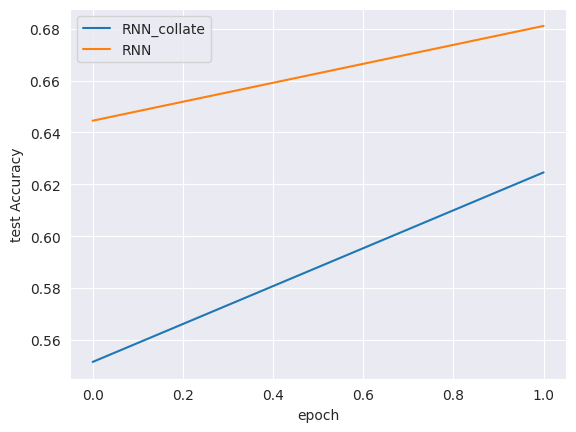

In [91]:
sns.lineplot(x='epoch', y='test Accuracy', data=result_e6_1, label='RNN_collate')
sns.lineplot(x='epoch', y='test Accuracy', data=result_e6_2, label='RNN')

Conclusion: Removing half of the training data from the batch and training for 2 epochs results in worse performance than training with full batch for 1 epoch.
My guess is that with more data per batch, we get "better" gradients and therefore make a "bigger" step towards a gradient's minimum.

# Excercise 7
Compare training a three-layer bidirectional RNN with batch sizes of B = {1, 2, 4, 8} for five epochs.
Which batch size seems to give the best balance between speed and accuracy?

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Training:   0%|          | 0/19773 [00:00<?, ?it/s]

Testing:   0%|          | 0/301 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/9887 [00:00<?, ?it/s]

Testing:   0%|          | 0/151 [00:00<?, ?it/s]

Training:   0%|          | 0/9887 [00:00<?, ?it/s]

Testing:   0%|          | 0/151 [00:00<?, ?it/s]

Training:   0%|          | 0/9887 [00:00<?, ?it/s]

Testing:   0%|          | 0/151 [00:00<?, ?it/s]

Training:   0%|          | 0/9887 [00:00<?, ?it/s]

Testing:   0%|          | 0/151 [00:00<?, ?it/s]

Training:   0%|          | 0/9887 [00:00<?, ?it/s]

Testing:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/4944 [00:00<?, ?it/s]

Testing:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/4944 [00:00<?, ?it/s]

Testing:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/4944 [00:00<?, ?it/s]

Testing:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/4944 [00:00<?, ?it/s]

Testing:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/4944 [00:00<?, ?it/s]

Testing:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

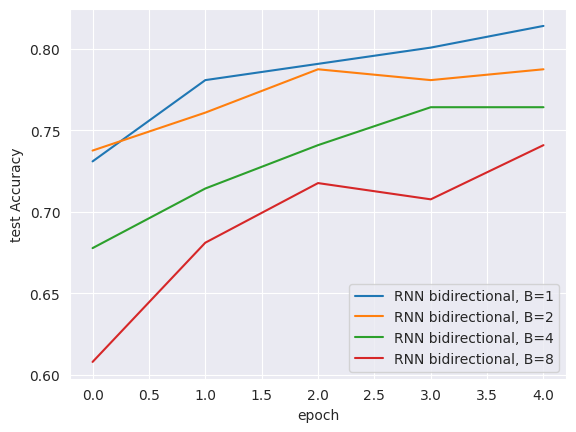

In [92]:
import time

e7_result = []

for i, batch_size in enumerate([1, 2, 4, 8]):
    rnn_3layer_bidir = nn.Sequential(
        EmbeddingPackable(nn.Embedding(vocab_size, D)),
        nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True),
        LastTimeStep(rnn_layers=3, bidirectional=True),
        nn.Linear(hidden_nodes*2, classes),
    )
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_and_pack)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_and_pack)

    start_time = time.time()
    iteration_training_result = train_simple_network(rnn_3layer_bidir, loss_func, train_loader,
                                   test_loader=test_loader,
                                   score_funcs=score_funcs,
                                   device=device, epochs=5)
    train_duration = time.time() - start_time

    iteration_result = {"batch_size" : batch_size, "train_duration" : train_duration, "result" : iteration_training_result}
    e7_result.append(iteration_result)
    sns.lineplot(x='epoch', y='test Accuracy', data=iteration_training_result, label=f'RNN bidirectional, B={batch_size}')

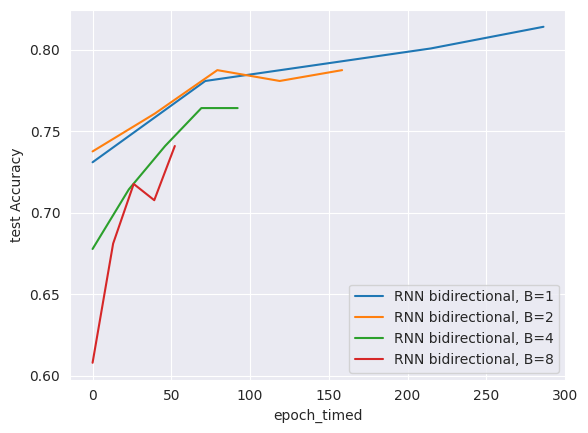

In [93]:
from pandas import DataFrame

e7_durations = []

data=DataFrame(e7_result)

for iteration_result in e7_result:
    epoch_duration = iteration_result["train_duration"] / 5
    iteration_result["result"]["epoch_timed"] = iteration_result["result"]["epoch"] * epoch_duration

    sns.lineplot(x='epoch_timed', y='test Accuracy', data=iteration_result["result"], label=f'RNN bidirectional, B={iteration_result["batch_size"]}')

Conclusion: Higher batch size value results in lower accuracy after 1 epoch, but seems to converge faster.
However, I probably need more experiments and\or epochs to be more confident in this.